In [1]:
import numpy as np

import torch

from torch.utils.data import DataLoader

from models.wgan_camel import Discriminator, Generator

from tqdm.auto import trange, tqdm

import matplotlib.pyplot as plt
%matplotlib inline

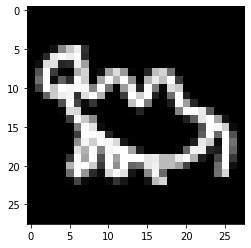

In [2]:
real_images = np.load("../data/camel/full_numpy_bitmap_camel.npy").reshape((-1, 1, 28, 28)).astype(np.float32) / 255
plt.imshow(real_images[0][0], cmap='gray')
plt.show()

In [24]:
generator = Generator().cuda()
critic = Discriminator().cuda()

optimizer_G = torch.optim.RMSprop(generator.parameters(), lr=5e-5)
optimizer_C = torch.optim.RMSprop(critic.parameters(), lr=5e-5)

In [25]:
N_EPOCHS = 10
BATCH_SIZE = 64
N_CRITIC_UPDATES = 5

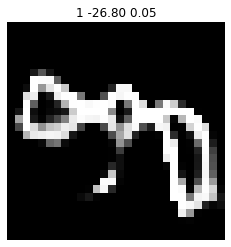

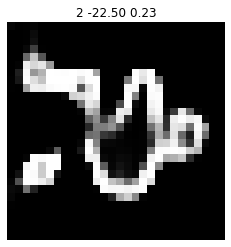

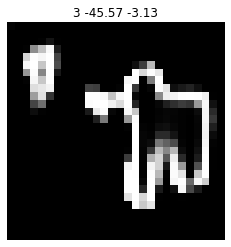

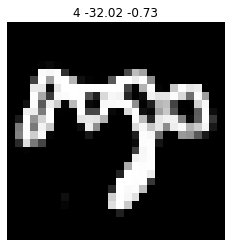

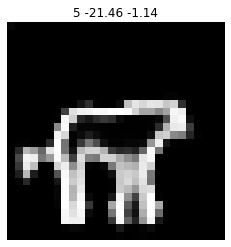

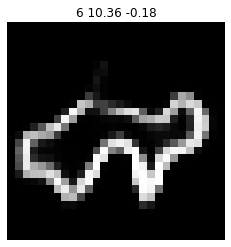

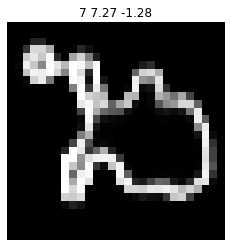

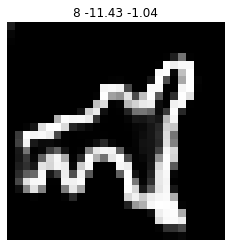

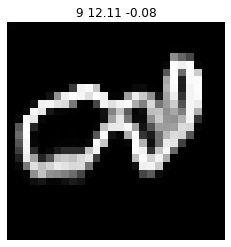

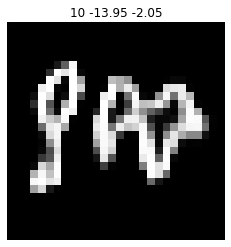

In [29]:
image_loader = DataLoader(real_images, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)

g_losses = []
c_losses = []

for epoch in range(N_EPOCHS):
    t = tqdm(image_loader, desc=f"Epoch {epoch}. g_loss {0.0:.2f} c_loss {0.0:.2f}")
    for i, real_imgs in enumerate(t):

        z = torch.randn(BATCH_SIZE, 100, requires_grad=True)
        gen_imgs = generator(z.cuda())

        if i % N_CRITIC_UPDATES == 0:
            # train generator
            critic.eval()
            generator.train()
            optimizer_G.zero_grad()

            g_loss = -torch.mean(critic(gen_imgs))
            g_losses.append(g_loss.item())

            g_loss.backward()
            optimizer_G.step()

        # train discriminator
        generator.eval()
        critic.train()
        optimizer_C.zero_grad()

        c_loss = -torch.mean(critic(real_imgs.cuda()) - critic(gen_imgs.detach())) / 2
        c_losses.append(c_loss)

        c_loss.backward()
        optimizer_C.step()

        for p in critic.parameters():
            p.data.clamp_(-0.01, 0.01)

        if i % 10 == 0:
            t.set_description(f"Epoch {epoch}. g_loss {g_loss.item():.2f} c_loss {c_loss.item():.2f}")

    plt.figure()
    plt.title(f"{epoch+1} {g_loss.item():.2f} {c_loss.item():.2f}")
    plt.axis("off")
    generator.eval()
    plt.imshow(generator(torch.randn(1, 100).cuda()).cpu().detach().squeeze(), cmap='gray')
    plt.show()

    torch.save(generator.state_dict(), "models/generator_wgan_camel.pt")
    torch.save(critic.state_dict(), "models/critic_wgan_camel.pt")

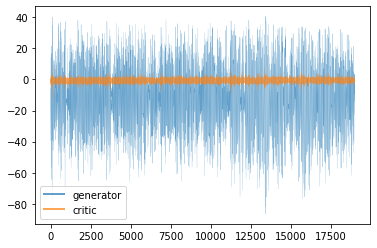

In [30]:
plt.plot(np.arange(0, len(g_losses))*5, g_losses, label='generator', alpha=0.7, linewidth=0.2)
plt.plot(c_losses, label='critic', alpha=0.7, linewidth=0.2)
leg = plt.legend()
for i in range(2):
    leg.get_lines()[i].set_linewidth(2)
plt.show()

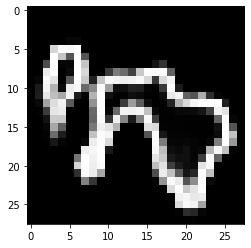

In [34]:
generator.eval()
plt.imshow(generator(torch.randn(1, 100).cuda()).cpu().detach().squeeze(), cmap='gray')